In [3]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import sigpy
sys.path.append('../../../src/')

# custom scripts
import mri_cs
from undersampling import radial_sampling
from helpers import calculate_metrics, get_proportion, zero_fill, create_mask

from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0)

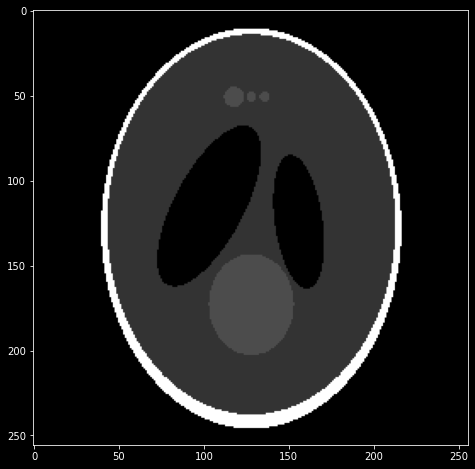

In [4]:
phantom = sigpy.shepp_logan((256, 256))
rows, cols = phantom.shape
_ = plt.imshow(np.abs(phantom), cmap="gray")

0.0791168212890625

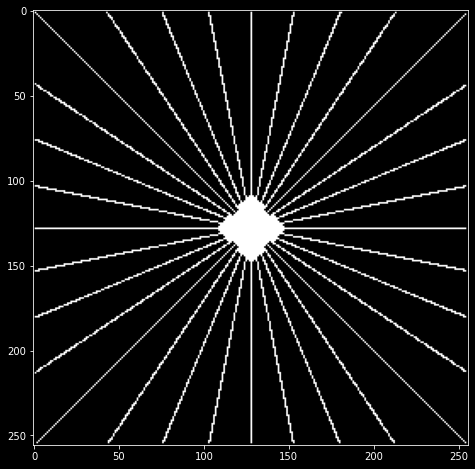

In [5]:
radial_mask = np.fft.fftshift(radial_sampling(rows, cols, 32, dilations=0))
samples_rows = np.where(radial_mask.flatten())[0]
b = np.fft.fft2(phantom).flatten()[samples_rows]

get_proportion(phantom.flatten(), b)
_ = plt.imshow(np.fft.fftshift(radial_mask))

PSNR: 19.922996530904836
SSIM: 0.30438127746616445
SNR: 6.590090835878178
MSE: 0.013424024462264846


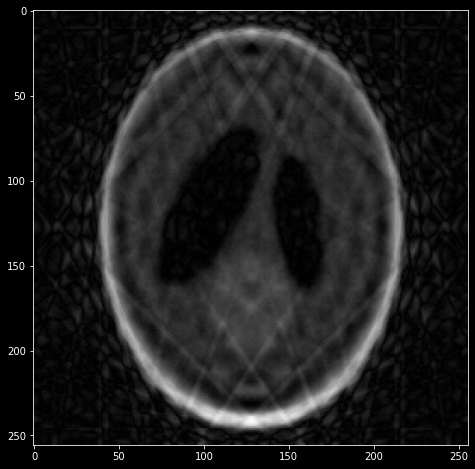

In [6]:
zero_filled = zero_fill(b, samples_rows, rows, cols)

_ = plt.imshow(np.abs(zero_filled))
_ = calculate_metrics(np.abs(phantom), np.abs(zero_filled))

# No prior information LP minimization

In [7]:
filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 21.616517543792725s


PSNR: 31.776908452666895
SSIM: 0.8234194401565108
SNR: 18.147671968258766
MSE: 0.0009378310807819102


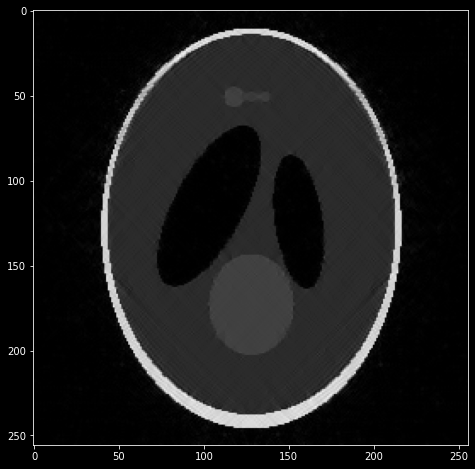

In [6]:
import mri_cs
reload(mri_cs)

rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30

nopi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 verbose=False)

plt.imshow(np.abs(nopi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(nopi_recon))

# Visualizing prior information leveraged

<module 'mri_cs' from '../../../src/mri_cs.py'>

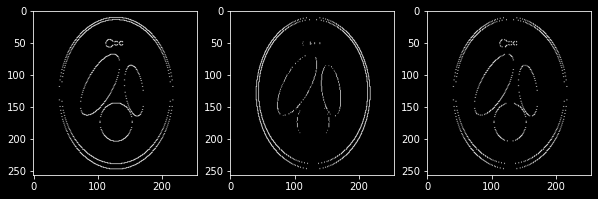

In [18]:
reload(mri_cs)
phi = mri_cs.prior_information(np.abs(phantom), pi_prop=10/100, filters=filters)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
_ = ax1.imshow(create_mask(phi[0]))
_ = ax2.imshow(create_mask(phi[1]))
_ = ax3.imshow(create_mask(phi[2]))

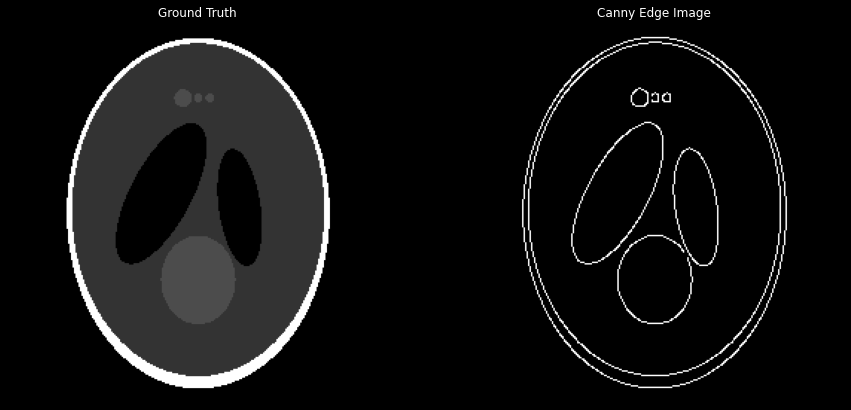

In [20]:
import cv2

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(15)
_ = ax[0].imshow(np.abs(phantom))
_ = ax[0].set_title('Ground Truth')
_ = ax[0].axis('off')

# _ = ax[1].imshow(np.abs(phantom))
_ = ax[1].imshow(auto_canny(img_as_ubyte(abs_phantom)))
_ = ax[1].set_title('Canny Edge Image')
_ = ax[1].axis('off')

In [10]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
noisy_img = create_mask(phi[0])

bil_img = denoise_bilateral(noisy_img)
tv_cham_img = denoise_tv_chambolle(noisy_img, weight=0.1)
wav_img = denoise_wavelet(noisy_img, rescale_sigma=True)

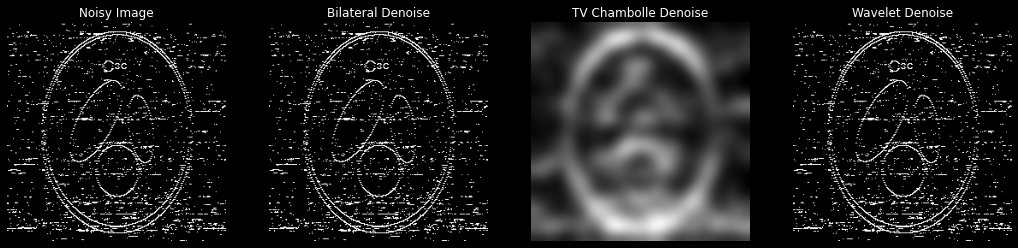

In [11]:
# with plt.figure(figsize=(10, 9)):
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(18)
_ = ax[0].imshow(noisy_img)
_ = ax[0].set_title('Noisy Image')
_ = ax[0].axis('off')

_ = ax[1].imshow(bil_img)
_ = ax[1].set_title('Bilateral Denoise')
_ = ax[1].axis('off')

_ = ax[2].imshow(tv_cham_img)
_ = ax[2].set_title('TV Chambolle Denoise')
_ = ax[2].axis('off')

_ = ax[3].imshow(wav_img)
_ = ax[3].set_title('Wavelet Denoise')
_ = ax[3].axis('off')

# LP Minimization with pre filtering and prior information

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 18.328235387802124s
PSNR: 75.13280718177838
SSIM: 0.9999827346103897
SNR: 62.988138237434306
MSE: 3.0766492990728543e-08


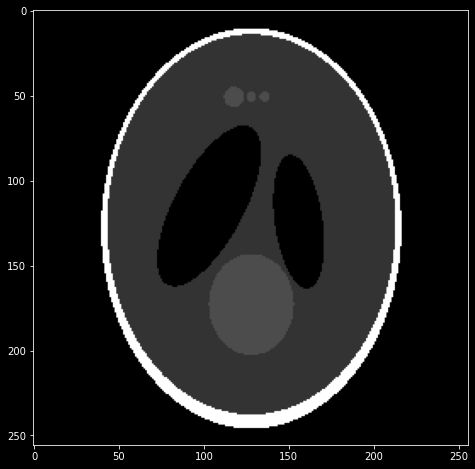

In [20]:
import mri_cs
reload(mri_cs)

rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30
tau = 1e-1

pi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                               p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                               number_jobs=1, maxiterperstage=maxiterperstage,
                               phi=phi, tau=tau, verbose=False)

_ = plt.imshow(np.abs(pi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(pi_recon))